# Import Libraries

In [1]:
# Data fetching library
import requests as req
# used below: 'res' stands for 'response'

# File management library
import os

# Configure logging library
import logging
import sys
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

# Data manipulation libraries
import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
import json
from datetime import datetime

# Data analysis libraries
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Uploading results to Carto
import cartoframes

# Data visualization library
## Uses Vega-Lite, which can be easily put in websites
from vega3 import Vega
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data from RW API

In [2]:
# Base URL for getting dataset metadata from RW API
url = "https://api.resourcewatch.org/v1/dataset?sort=slug,-provider,userId&status=saved&published=true&includes=metadata,vocabulary,widget,layer"

# page[size] tells the API the maximum number of results to send back
# There are currently between 200 and 300 datasets on the RW API
payload = { "application":"rw", "page[size]": 1000}

# Request all datasets, and extract the data from the response
res = req.get(url, params=payload)
data = res.json()["data"]

### Convert the json object returned by the API into a pandas DataFrame
# Another option: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html
datasets_on_api = {}
for ix, dset in enumerate(data):
    atts = dset["attributes"]
    metadata = atts["metadata"]
    layers = atts["layer"]
    widgets = atts["widget"]
    tags = atts["vocabulary"]
    datasets_on_api[dset["id"]] = {
        "name":atts["name"],
        "table_name":atts["tableName"],
        "provider":atts["provider"],
        "date_updated":atts["updatedAt"],
        "num_metadata":len(metadata),
        "metadata": metadata,
        "num_layers":len(layers),
        "layers": layers,
        "num_widgets":len(widgets),
        "widgets": widgets,
        "num_tags":len(tags),
        "tags":tags
    }

# Create the DataFrame, name the index, and sort by date_updated
# More recently updated datasets at the top
current_datasets_on_api = pd.DataFrame.from_dict(datasets_on_api, orient='index')
current_datasets_on_api.index.rename("Dataset", inplace=True)
current_datasets_on_api.sort_values(by=["date_updated"], inplace=True, ascending = False)

# Select all Carto datasets on the API:
provider = "cartodb"
carto_ids = (current_datasets_on_api["provider"]==provider)
carto_data = current_datasets_on_api.loc[carto_ids]

logging.info("Number of Carto datasets: " + str(carto_data.shape[0]))

INFO:root:Number of Carto datasets: 139


# Find data sets to run the analysis with

In [3]:
# Select only national level data sets

def pick_spatial_resolution(mdatas):
    for mdata in mdatas:
        if mdata['attributes']['language'] == 'en':
            return mdata['attributes']['info'].get('spatial_resolution', None)

def pick_temporal_resolution(mdatas):
    for mdata in mdatas:
        if mdata['attributes']['language'] == 'en':
            return mdata['attributes']['info'].get('frequency_of_updates', None)
        
carto_data.loc[:,'spatial_resolution'] = list(map(pick_spatial_resolution, carto_data['metadata']))
carto_data.loc[:,'temporal_resolution'] = list(map(pick_temporal_resolution, carto_data['metadata']))

national_datasets = carto_data[carto_data['spatial_resolution'] == 'National']
annual_national_datasets = national_datasets[national_datasets['temporal_resolution'] == 'Annual']

logging.info("{} annual, national level data sets".format(annual_national_datasets.shape[0]))
annual_national_datasets.shape

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
INFO:root:32 annual, national level data sets


(32, 14)

In [4]:
# Exclude MaterialFlows as this is handled in another notebook
annual_national_datasets.drop('082e2262-c58e-46a0-b6b7-56083cfcbd34', inplace=True)

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Find which data sets cover the right years

### Find year column

In [5]:
def inquire_columns(info):
    ds_id, table_name = info
    print(ds_id)
    # Template query string used to query RW datasets
    q = "https://api.resourcewatch.org/v1/query/{}?sql=SELECT * FROM {} LIMIT 1".format(ds_id,table_name)
    try:
        res = req.get(q).json()['data'][0]
        keys = res.keys()
        types = [type(val) for key, val in res.items()]
        return (keys, types)
    except:
        return (None, None)
    
# Collect column names
annual_national_datasets.loc[:, 'column_names'], annual_national_datasets.loc[:, 'column_types'] = zip(*list(map(inquire_columns, zip(annual_national_datasets.index,annual_national_datasets['table_name']))))

a7067e9f-fe40-4338-85da-13a6071c76fe
03bfb30e-829f-4299-bab9-b2be1b66b5d4
62c988a7-1e4d-418e-87bf-a743e24209e8
cc354f7f-2622-44cb-91c1-73559373de72
c665f519-eef9-4f67-a8bf-7e3e6dc8bfcd
d3a6b89f-cf5c-40cf-b2b3-ac1c8315c648
1b97e47e-ca18-4e50-9aae-a2853acca3f0
6e10074a-a368-4afd-8564-db59814cdb74
10337db6-8321-445e-a60b-28fc1e114f29
d446a52e-c4c1-4e74-ae30-3204620a0365
52c55378-0484-48c3-92fc-3ee94d21c716
fa6443ff-eb95-4d0f-84d2-f0c91682efdf
a290675c-9528-4a51-8201-f6c2d7848744
c18a38cd-94ff-48cd-818f-6ffb05992abb
fe311144-8c0e-4440-b068-6efd057e0f6a
37d04efc-0ab2-4499-a891-54dca1013c74
b37048be-9b23-4458-a047-888956c69aa1
8671f536-1979-4b6f-a147-70152fcb44ed
00abb46f-34e2-4bf7-be30-1fb0b1de022f
a89c95c7-0b82-4162-b9d8-cc0205e9f7ec
bea122ce-1e4b-465d-8b7b-fa11aadd20f7
95b013a3-389a-4367-83b7-c9d68c28c406
d38d0d5c-31b1-47f4-9d2e-d8fba4c7d083
2e31a1f3-576b-46b4-84f0-3f0cc399f887
11278cb6-b298-49a1-bf71-f1e269f40758
7a551dd8-b59c-4f59-9d50-c92cb61c5799
ccfb322a-20aa-4132-b58b-0f76acec8f5a
1

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
ix = 3
print(annual_national_datasets.iloc[ix]['column_names'])
print(annual_national_datasets.iloc[ix]['column_types'])

In [6]:
# Making the choice to only accept datetime and year as column names.
# Datetimes will be string timestamps, years will be ints
def pick_year_col(column_names):
    print("Available column names: {}".format(column_names))
    if 'datetime' in column_names:
        return 'datetime'
    elif 'year' in column_names:
        return 'year'
    else:
        return None
        #year_col = input("What is the year column called? Type nothing for None")
        #return year_col if year_col else None

annual_national_datasets.loc[:, 'year_col'] = list(map(pick_year_col, annual_national_datasets['column_names']))

Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'a_aggr', 'add_a', 'add_b', 'b_aggr', 'c_aggr', 'cartodb_georef_status', 'cl_aggr', 'cl_rating', 'country', 'd_aggr', 'e_aggr', 'f_aggr', 'g_aggr', 'index', 'pr_aggr', 'pr_rating', 'rw_country_code', 'rw_country_name', 'status', 'total_aggr', 'status_text'])
Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'country', 'employment_of_total_labour_force', 'employment_pulp_and_paper_1000', 'employment_roundwood_production_1000', 'employment_total_for_the_forest_sector_1000', 'employment_wood_processing_1000', 'gross_value_added_contribution_to_gdp', 'gross_value_added_pulp_and_paper_us_million', 'gross_value_added_roundwood_production_us_million', 'gross_value_added_total_for_the_forest_sector_us_million', 'gross_value_added_wood_processing_us_million', 'year', 'rw_country_code', 'rw_country_name'])
Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_w

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
annual_national_datasets['year_col']

Dataset
a7067e9f-fe40-4338-85da-13a6071c76fe        None
03bfb30e-829f-4299-bab9-b2be1b66b5d4        year
62c988a7-1e4d-418e-87bf-a743e24209e8        year
cc354f7f-2622-44cb-91c1-73559373de72    datetime
c665f519-eef9-4f67-a8bf-7e3e6dc8bfcd    datetime
d3a6b89f-cf5c-40cf-b2b3-ac1c8315c648    datetime
1b97e47e-ca18-4e50-9aae-a2853acca3f0    datetime
6e10074a-a368-4afd-8564-db59814cdb74    datetime
10337db6-8321-445e-a60b-28fc1e114f29    datetime
d446a52e-c4c1-4e74-ae30-3204620a0365    datetime
52c55378-0484-48c3-92fc-3ee94d21c716    datetime
fa6443ff-eb95-4d0f-84d2-f0c91682efdf    datetime
a290675c-9528-4a51-8201-f6c2d7848744        year
c18a38cd-94ff-48cd-818f-6ffb05992abb    datetime
fe311144-8c0e-4440-b068-6efd057e0f6a        None
37d04efc-0ab2-4499-a891-54dca1013c74    datetime
b37048be-9b23-4458-a047-888956c69aa1    datetime
8671f536-1979-4b6f-a147-70152fcb44ed    datetime
00abb46f-34e2-4bf7-be30-1fb0b1de022f    datetime
a89c95c7-0b82-4162-b9d8-cc0205e9f7ec    datetime
bea122ce-1e4

### Find dates covered by each dataset

In [8]:
def try_datetime_conversion_to_year(possible_dt):
    DATE_FORMAT = '%Y-%m-%dT%H:%M:%SZ'
    try:
        return datetime.strptime(possible_dt, DATE_FORMAT).year
    except:
        return int(possible_dt)

def find_years_covered(info):
    ds_id, year_col, table_name = info
    if year_col:
        print(ds_id)
        # Template query string used to query RW datasets
        q = "https://api.resourcewatch.org/v1/query/{}?sql=SELECT {} FROM {}".format(ds_id,year_col,table_name)
        print(q)
        try:
            res = pd.DataFrame(req.get(q).json()['data'])
            unique_years = res[year_col].unique()
            print(unique_years)
            int_years = list(map(try_datetime_conversion_to_year, unique_years))
            return sorted(int_years)
        except:
            return None
    else:
        return None
    
annual_national_datasets.loc[:, 'years_covered'] = list(map(find_years_covered, zip(annual_national_datasets.index, annual_national_datasets['year_col'], annual_national_datasets['table_name'])))

03bfb30e-829f-4299-bab9-b2be1b66b5d4
https://api.resourcewatch.org/v1/query/03bfb30e-829f-4299-bab9-b2be1b66b5d4?sql=SELECT year FROM for_020_forest_employment_gdp_edit
[None]
62c988a7-1e4d-418e-87bf-a743e24209e8
https://api.resourcewatch.org/v1/query/62c988a7-1e4d-418e-87bf-a743e24209e8?sql=SELECT year FROM com_028_effect_of_ag_prices_on_commodity_prices
[2015 2012 2014 2011 2013 2009 2010]
cc354f7f-2622-44cb-91c1-73559373de72
https://api.resourcewatch.org/v1/query/cc354f7f-2622-44cb-91c1-73559373de72?sql=SELECT datetime FROM soc_074_employment_in_agriculture
['1991-01-01T00:00:00Z' '1992-01-01T00:00:00Z' '1995-01-01T00:00:00Z'
 '1996-01-01T00:00:00Z' '1997-01-01T00:00:00Z' '1998-01-01T00:00:00Z'
 '1999-01-01T00:00:00Z' '2000-01-01T00:00:00Z' '2002-01-01T00:00:00Z'
 '2005-01-01T00:00:00Z' '2009-01-01T00:00:00Z' '2011-01-01T00:00:00Z'
 '2012-01-01T00:00:00Z' '2014-01-01T00:00:00Z' '2015-01-01T00:00:00Z'
 '2017-01-01T00:00:00Z' '1993-01-01T00:00:00Z' '1994-01-01T00:00:00Z'
 '2001-01-01T

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
annual_national_datasets['years_covered']

Dataset
a7067e9f-fe40-4338-85da-13a6071c76fe                                                 None
03bfb30e-829f-4299-bab9-b2be1b66b5d4                                                 None
62c988a7-1e4d-418e-87bf-a743e24209e8           [2009, 2010, 2011, 2012, 2013, 2014, 2015]
cc354f7f-2622-44cb-91c1-73559373de72    [1991, 1992, 1993, 1994, 1995, 1996, 1997, 199...
c665f519-eef9-4f67-a8bf-7e3e6dc8bfcd    [2000, 2007, 2008, 2009, 2010, 2011, 2012, 201...
d3a6b89f-cf5c-40cf-b2b3-ac1c8315c648    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...
1b97e47e-ca18-4e50-9aae-a2853acca3f0    [1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...
6e10074a-a368-4afd-8564-db59814cdb74    [1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...
10337db6-8321-445e-a60b-28fc1e114f29    [1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...
d446a52e-c4c1-4e74-ae30-3204620a0365    [1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...
52c55378-0484-48c3-92fc-3ee94d21c716    [1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...
fa

In [10]:
def determine_if_analysis_possible(years_covered):
    flag = False
    try:
        if (2000 in years_covered) and (2015 in years_covered):
            flag = True
    except:
        pass
    return flag

annual_national_datasets.loc[:, 'analysis_possible'] = list(map(determine_if_analysis_possible, annual_national_datasets['years_covered']))

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
annual_national_datasets['analysis_possible'] 

Dataset
a7067e9f-fe40-4338-85da-13a6071c76fe    False
03bfb30e-829f-4299-bab9-b2be1b66b5d4    False
62c988a7-1e4d-418e-87bf-a743e24209e8    False
cc354f7f-2622-44cb-91c1-73559373de72     True
c665f519-eef9-4f67-a8bf-7e3e6dc8bfcd    False
d3a6b89f-cf5c-40cf-b2b3-ac1c8315c648    False
1b97e47e-ca18-4e50-9aae-a2853acca3f0     True
6e10074a-a368-4afd-8564-db59814cdb74    False
10337db6-8321-445e-a60b-28fc1e114f29     True
d446a52e-c4c1-4e74-ae30-3204620a0365    False
52c55378-0484-48c3-92fc-3ee94d21c716     True
fa6443ff-eb95-4d0f-84d2-f0c91682efdf     True
a290675c-9528-4a51-8201-f6c2d7848744    False
c18a38cd-94ff-48cd-818f-6ffb05992abb     True
fe311144-8c0e-4440-b068-6efd057e0f6a    False
37d04efc-0ab2-4499-a891-54dca1013c74     True
b37048be-9b23-4458-a047-888956c69aa1     True
8671f536-1979-4b6f-a147-70152fcb44ed     True
00abb46f-34e2-4bf7-be30-1fb0b1de022f     True
a89c95c7-0b82-4162-b9d8-cc0205e9f7ec    False
bea122ce-1e4b-465d-8b7b-fa11aadd20f7     True
95b013a3-389a-4367-83b7-c9

### Pick the value column to use

In [12]:
def pick_value_col(info):
    analysis_possible = info[0]
    column_names = info[1]
    if analysis_possible:
        print("Available column names: {}".format(column_names))
        if 'yr_data' in column_names:
            return 'yr_data'
        elif 'total_data' in column_names:
            return 'total_data'
        else:
            value_col = input("What is the value column called? Type nothing for None")
            return value_col if value_col else None
    else:
        return None

annual_national_datasets.loc[:, 'value_col'] = list(map(pick_value_col, zip(annual_national_datasets['analysis_possible'], annual_national_datasets['column_names'])))

Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'country_name', 'country_code', 'rw_country_code', 'rw_country_name', 'datetime', 'yr_data'])
Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'index', 'country_code', 'country_name', 'datetime', 'urban_data', 'rural_data', 'total_data', 'rw_country_code', 'rw_country_name'])
Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', '_2012_2015_avg', 'country', 'datetime', 'rw_country_code', 'rw_country_name', 'yr_data'])
Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'country_code', 'country_name', 'datetime', 'index', 'indicator_code', 'indicator_name', 'rw_country_code', 'rw_country_name', 'yr_data'])
Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'country', 'datetime', 'gain_data', 'readiness_data', 'rw_country_code', 'rw_country_name', 'vulnerability_data'])
Wh

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Pick the country column to use

In [13]:
def pick_country_col(column_names):
    print("Available column names: {}".format(column_names))
    if 'rw_country_code' in column_names:
        return 'rw_country_code'
    else:
        country_col = input("What is the country column called? Type nothing for None")
        return country_col if country_col else None

annual_national_datasets.loc[:, 'country_col'] = list(map(pick_country_col, annual_national_datasets['column_names']))

Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'a_aggr', 'add_a', 'add_b', 'b_aggr', 'c_aggr', 'cartodb_georef_status', 'cl_aggr', 'cl_rating', 'country', 'd_aggr', 'e_aggr', 'f_aggr', 'g_aggr', 'index', 'pr_aggr', 'pr_rating', 'rw_country_code', 'rw_country_name', 'status', 'total_aggr', 'status_text'])
Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'country', 'employment_of_total_labour_force', 'employment_pulp_and_paper_1000', 'employment_roundwood_production_1000', 'employment_total_for_the_forest_sector_1000', 'employment_wood_processing_1000', 'gross_value_added_contribution_to_gdp', 'gross_value_added_pulp_and_paper_us_million', 'gross_value_added_roundwood_production_us_million', 'gross_value_added_total_for_the_forest_sector_us_million', 'gross_value_added_wood_processing_us_million', 'year', 'rw_country_code', 'rw_country_name'])
Available column names: dict_keys(['cartodb_id', 'the_geom', 'the_geom_w

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Preview datasets to run analysis with

In [14]:
analyse_these = annual_national_datasets[annual_national_datasets['analysis_possible']==True]

analyse_these

,name,table_name,provider,date_updated,num_metadata,metadata,num_layers,layers,num_widgets,widgets,num_tags,tags,spatial_resolution,temporal_resolution,column_names,column_types,year_col,years_covered,analysis_possible,value_col,country_col
Dataset,,,,,,,,,,,,,,,,,,,,,
cc354f7f-2622-44cb-91c1-73559373de72,soc.074 Employment_in_agriculture,soc_074_employment_in_agriculture,cartodb,2018-04-09T14:28:42.603Z,1,"[{'id': '5ab72ec06f76b50012aeef07', 'type': 'm...",1,[{'id': '0a8fbc9a-c05d-421d-bedf-15ebb1e0c4f5'...,4,[{'id': 'd4f32fb9-9cc9-44b3-9abd-72ae78b43921'...,1,"[{'type': 'vocabulary', 'attributes': {'resour...",National,Annual,"(cartodb_id, the_geom, the_geom_webmercator, c...","[<class 'int'>, <class 'NoneType'>, <class 'No...",datetime,"[1991, 1992, 1993, 1994, 1995, 1996, 1997, 199...",True,yr_data,rw_country_code
1b97e47e-ca18-4e50-9aae-a2853acca3f0,wat.005 Access to Improved Water Source,wat_005_improved_water_access,cartodb,2018-04-05T20:08:25.411Z,2,"[{'id': '59d79d8ae353f300125c0dec', 'type': 'm...",3,[{'id': '14bfb1ca-a672-4bec-8060-b8e51a5f21bc'...,5,[{'id': '8a648a08-537e-403b-90a6-dc84efff3029'...,1,"[{'type': 'vocabulary', 'attributes': {'resour...",National,Annual,"(cartodb_id, the_geom, the_geom_webmercator, i...","[<class 'int'>, <class 'NoneType'>, <class 'No...",datetime,"[1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...",True,total_data,rw_country_code
10337db6-8321-445e-a60b-28fc1e114f29,cit.029 Municipal Waste,cit_029_municipal_waste,cartodb,2018-04-03T14:37:03.920Z,2,"[{'id': '59dd3a069caa8700129be7cb', 'type': 'm...",1,[{'id': '2800bf8d-6d27-4a77-a621-ef65cf44c7bf'...,2,[{'id': '32caf06d-b02a-440a-ac60-ba4ebec4ffb3'...,1,"[{'type': 'vocabulary', 'attributes': {'resour...",National,Annual,"(cartodb_id, the_geom, the_geom_webmercator, _...","[<class 'int'>, <class 'NoneType'>, <class 'No...",datetime,"[1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...",True,yr_data,rw_country_code
52c55378-0484-48c3-92fc-3ee94d21c716,com.010 Gross Domestic Product,com_010_gdp_ppp_usd,cartodb,2018-03-30T18:30:22.879Z,2,"[{'id': '59dce62e991d67001321650c', 'type': 'm...",1,[{'id': 'f98f8874-3d5d-4818-a75c-29a8d1b57cb3'...,3,[{'id': 'e36177f8-0c00-499d-9036-c98d06f03d47'...,1,"[{'type': 'vocabulary', 'attributes': {'resour...",National,Annual,"(cartodb_id, the_geom, the_geom_webmercator, c...","[<class 'int'>, <class 'NoneType'>, <class 'No...",datetime,"[1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...",True,yr_data,rw_country_code
fa6443ff-eb95-4d0f-84d2-f0c91682efdf,cli.029 Vulnerability to Climate Change Index,cli_029_vulnerability_to_cc,cartodb,2018-03-27T17:12:41.548Z,2,"[{'id': '59a427ab7b6c000012baa707', 'type': 'm...",1,[{'id': '07b6e469-d1c4-4ab8-a8a7-cf37f344ae4c'...,3,[{'id': '8c44a854-63e7-4ce6-b864-4858c7394852'...,1,"[{'type': 'vocabulary', 'attributes': {'resour...",National,Annual,"(cartodb_id, the_geom, the_geom_webmercator, c...","[<class 'int'>, <class 'NoneType'>, <class 'No...",datetime,"[1995, 1996, 1997, 1998, 1999, 2000, 2001, 200...",True,gain_data,rw_country_code
c18a38cd-94ff-48cd-818f-6ffb05992abb,com.015 Recycled waste,com_015_recycling_rates,cartodb,2018-03-13T19:24:38.231Z,2,"[{'id': '59d5390066b9630011465ed0', 'type': 'm...",1,[{'id': '95557b73-07c5-48a6-841b-58f9d782b58e'...,2,[{'id': 'c77bc834-d1e6-4b5b-91de-81e72dcfcb9d'...,1,"[{'type': 'vocabulary', 'attributes': {'resour...",National,Annual,"(cartodb_id, the_geom, the_geom_webmercator, _...","[<class 'int'>, <class 'NoneType'>, <class 'No...",datetime,"[1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...",True,yr_data,rw_country_code
37d04efc-0ab2-4499-a891-54dca1013c74,soc.040 Access to Improved Sanitation Facilities,soc_040_improved_sanitation,cartodb,2018-03-13T16:25:26.530Z,2,"[{'id': '59dd226d26cb7a0013147ab1', 'type': 'm...",3,[{'id': 'e01c4ff1-94a8-466c-a494-85dfc6a54b36'...,3,[{'id': 'ac7c76c3-481e-42f5-9db8-d61d6f47b4d3'...,1,"[{'type': 'vocabulary', 'attributes': {'resour...",National,Annual,"(cartodb_id, the_geom, the_geom_webmerc

# Run the analysis

In [15]:
def run_linear_regressions(datax, xyear, xval_col, xcountry_col, xname,
                           datay_from_rwapi, ystartyear, yendyear,
                           test_size):
    ''' 
    Inputs: Data and needed column names
    Outputs: square matrix of regression coefficients for each indicator
    '''
    
    #datay_from_rw_api
    #yprod_col, yflow_col,yyear_col, yval_col,ycountry_col,
    
    # Result will be an upper right triangular square matrix in 4 dimensions
    results = {}    
    
    all_countries = datax[xcountry_col].unique()
    msg = "regressing GHG-GDP Divergence Index against {}"
    q_yr = "https://api.resourcewatch.org/v1/query/{}?sql=SELECT {}, {} FROM {} WHERE {}={}"#.format(ds_id,value_col,country_col,table_name,year_col,target_year)
    q_dt = "https://api.resourcewatch.org/v1/query/{}?sql=SELECT {}, {} FROM {} WHERE EXTRACT(year from {})={}"#.format(ds_id,value_col,country_col,table_name,year_col,target_year)
    
    for ds in datay_from_rwapi.iterrows():
        
        ds_id = ds[0]        
        table_name = ds[1]['table_name']
        year_col = ds[1]['year_col']
        value_col = ds[1]['value_col']
        country_col = ds[1]['country_col']
        
        if not (year_col and value_col and country_col and table_name):
            results[ds_id] = 'Some missing information'
            continue
        
        logging.info(msg.format(table_name))
    
        # Extract data
        # TO DO: allow for year ranges
        data_x = datax.copy()

        if year_col == 'datetime':
            res = req.get(q_dt.format(ds_id,value_col,country_col,table_name,year_col,ystartyear))
        elif year_col == 'year':
            res = req.get(q_yr.format(ds_id,value_col,country_col,table_name,year_col,ystartyear))
        else:
            continue
            
        try:
            data_y_start = pd.DataFrame(res.json()['data'])
        except:
            print(res.text)
            
        data_y_start = data_y_start.set_index(country_col)
        # Avoid division by 0
        data_y_start = data_y_start.loc[data_y_start[value_col] > 0]

        if year_col == 'datetime':
            res = req.get(q_dt.format(ds_id,value_col,country_col,table_name,year_col,yendyear))
        elif year_col == 'year':
            res = req.get(q_yr.format(ds_id,value_col,country_col,table_name,year_col,yendyear))
        else:
            continue
        
        try:
            data_y_end = pd.DataFrame(res.json()['data'])
        except:
            print(res.text)        
            
        data_y_end = data_y_end.set_index(country_col)

        logging.debug('Start {}'.format(data_y_start.head()))
        logging.debug('End {}'.format(data_y_end.head()))

        data_y = data_y_end[value_col].div(data_y_start[value_col])
        data_y = data_y[pd.notnull(data_y)]
        logging.debug('Change percent: {}'.format(data_y.head()))

        # Throw away all but intersection of countries
        logging.debug('data_x countries: {}'.format(set(data_x[xcountry_col])))
        logging.debug('data_y countries: {}'.format(set(data_y.index)))
        keep_countries = set(data_x[xcountry_col]) & set(data_y.index)
        skipped_countries = [country for country in all_countries if country not in keep_countries]

        data_x = data_x.set_index(xcountry_col).loc[keep_countries, xval_col]
        data_y = data_y.loc[keep_countries]

        # Reshape for regression
        data_x_reg = data_x.values.reshape(-1, 1)
        data_y_reg = data_y.values.reshape(-1, 1)

        if (len(data_x_reg)>test_size) & (len(data_y_reg)>test_size):
            pass
        else:
            results[ds_id] = {
                'r_squared': None,
                'skipped_countries': skipped_countries
            }
            continue

        # Split for training / test set
        X_train, X_test, y_train, y_test = train_test_split(data_x_reg, data_y_reg, 
                                                            test_size=test_size, random_state=42)

        # Run regression
        lm = linear_model.LinearRegression() 
        lm.fit(X_train, y_train)

        # Extract coefficient of determination (r^2)
        r_squared = lm.score(X_test, y_test)
        #y_pred = lm.predict(X_test)
        #r_squared2 = metrics.r2_score(y_test, y_pred)

        logging.info('rsquared: {}'.format(r_squared)) #, r_squared2))
        logging.info('num skipped countries: {}'.format(len(skipped_countries)))
        logging.info('num training countries: {}'.format(len(X_train)))
        logging.info('num testing countries: {}'.format(len(X_test)))

        # Store results
        results[ds_id] = {
            'r_squared': r_squared,
            'skipped_countries': skipped_countries
        }
        
        if r_squared > .02:
            results[ds_id]['data_x'] = data_x
            results[ds_id]['data_y'] = data_y
            
    return results    

In [16]:
DATAX = pd.read_csv('/Users/nathansuberi/Documents/GitHub/nsuberi.github.io/Compass Degrees for Summary Period.csv')
kwargs = {
    'datax': DATAX,
    'xname':'compass of divergence',
    'xyear': None,
    'xval_col': 'prod_degree',
    'xcountry_col': 'country',
    'datay_from_rwapi': annual_national_datasets[annual_national_datasets['analysis_possible']==True],
    'ystartyear': 2000,
    'yendyear': 2015,
    'test_size':30
}

regression_results = run_linear_regressions(**kwargs)

INFO:root:regressing GHG-GDP Divergence Index against soc_074_employment_in_agriculture
/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
INFO:root:rsquared: -2.926571619569687
INFO:root:num skipped countries: 17
INFO:root:num training countries: 136
INFO:root:num testing countries: 30
INFO:root:regressing GHG-GDP Divergence Index against wat_005_improved_water_access
INFO:root:rsquared: 0.014305347251079127
INFO:root:num skipped countries: 19
INFO:root:num training countries: 134
INFO:root:num testing countries: 30
INFO:root:regressing GHG-GDP Divergence Index against cit_029_municipal_waste
INFO:root:regressing GHG-GDP Divergence Index against com_010_gdp_ppp_usd
INFO:root:rsquared

In [20]:
#logging.info('Number of regressions attempted: {}'.format(len(regression_results)))
#logging.info('Results: {}'.format(regression_results))

def pick_not_null(d):
    new_d = dict()
    for key, vals in d.items():
        if vals['r_squared']:
            new_d[key] = vals
    return new_d

notnull_results = pick_not_null(regression_results)

sorted_results = sorted(notnull_results.items(), 
                        key=lambda res: res[1]['r_squared'], 
                        reverse=True)
             
# Only keep non-perfect correlations, 
# and ones for which no more than 10 countries are skipped
filterd_sorted_results = [res for res in sorted_results if 
                  (res[1]['r_squared'] < 1) and 
                  (len(res[1]['skipped_countries']) < 40) ]

filterd_sorted_results

[('37d04efc-0ab2-4499-a891-54dca1013c74', {'data_x': country
   THA     3.138693
   KEN    27.168960
   ECU    -7.600895
   ALB     8.000194
   CUB    12.470245
   GTM    11.817853
   BDI    39.943908
   BTN    10.788123
   COM   -23.705817
   ZWE   -57.996864
   FRA    89.199677
   SAU    -7.360214
   AUT    43.963467
   DJI     3.131709
   VNM   -12.928423
   NAM     7.274337
   ITA    45.456782
   MNE    15.763793
   BWA     9.491015
   IDN     3.563907
   TTO    -2.109656
   LBN    15.589928
   BLZ    20.791564
   GUY    21.457475
   MMR    38.222570
   AZE    40.084567
   IRN    -8.803775
   ARE    11.330744
   BHS   -41.437743
   HTI   -32.248478
   ZMB     8.173566
   KHM     0.432263
   CMR    -5.725056
   NER   -16.089663
   RWA    31.262633
   CHN    12.980903
   TON   -35.720392
   CAF   -75.326768
   MKD    76.643959
   BRA    -2.927058
   MUS     9.218408
   PRY    17.339127
   SLE   -10.054632
   IRQ   -12.373453
   AND    57.566213
   LBY   -23.186960
   SYC    31.148719

In [ ]:
analyse_these.loc['37d04efc-0ab2-4499-a891-54dca1013c74']

# Upload the results to Carto and RW API

## Authenticate to Carto

In [5]:
CARTO_USER = 'wri-rw'
CARTO_KEY = os.environ.get('CARTO_KEY', None)

cc = cartoframes.CartoContext(base_url='https://{}.carto.com/'.format(CARTO_USER),
                              api_key=CARTO_KEY)

## Format and upload table

In [7]:
x = filterd_sorted_results[0][1]['data_x'].values
y = filterd_sorted_results[0][1]['data_y'].values
df = pd.DataFrame({'x':x, 'y':y})
cc.write(df, 'com_xxx_ghg_gdp_highest_correlated_results', overwrite=True)

### Temporary - display results with matplotlib

In [8]:
data = cc.read('com_xxx_ghg_gdp_highest_correlated_results')

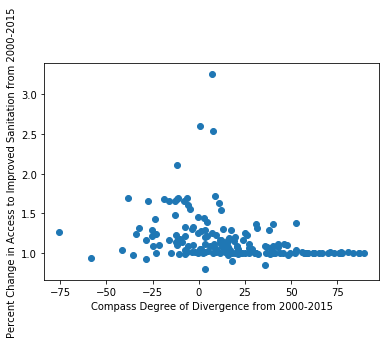

In [9]:
data = data[['x', 'y']]
plt.scatter(data['x'], data['y'])
plt.ylabel('Percent Change in Access to Improved Sanitation from 2000-2015')
plt.xlabel('Compass Degree of Divergence from 2000-2015')

# Configure the vega chart output, which can be uploaded to the RW API

### TO DO - make this actually work

In [ ]:
Config=''.join([
    "{\n",
    "  \"range\": {\n",
    "    \"dotSize\": [20, 250],\n",
    "    \"category\": [\n",
    "      \"#3BB2D0\",\n",
    "      \"#2C75B0\",\n",
    "      \"#FAB72E\",\n",
    "      \"#EF4848\",\n",
    "      \"#65B60D\",\n",
    "      \"#717171\"\n",
    "    ],\n",
    "    \"category20\": [\n",
    "      \"#3BB2D0\",\n",
    "      \"#2C75B0\",\n",
    "      \"#FAB72E\",\n",
    "      \"#EF4848\",\n",
    "      \"#65B60D\",\n",
    "      \"#C32D7B\",\n",
    "      \"#F577B9\",\n",
    "      \"#5FD2B8\",\n",
    "      \"#F1800F\",\n",
    "      \"#9F1C00\",\n",
    "      \"#A5E9E3\",\n",
    "      \"#B9D765\",\n",
    "      \"#393F44\",\n",
    "      \"#CACCD0\",\n",
    "      \"#717171\"\n",
    "    ],\n",
    "    \"ordinal\": { \"scheme\": \"greens\" },\n",
    "    \"ramp\": { \"scheme\": \"purples\" }\n",
    "  },\n",
    "  \"axis\": {\n",
    "    \"labelFontSize\": 13,\n",
    "    \"labelFont\": \"Lato\",\n",
    "    \"labelColor\": \"#717171\",\n",
    "    \"labelPadding\": 10,\n",
    "    \"ticks\": true,\n",
    "    \"tickSize\": 5,\n",
    "    \"tickColor\": \"#A9ABAD\",\n",
    "    \"tickOpacity\": 0.5,\n",
    "    \"tickExtra\": false\n",
    "  },\n",
    "  \"axisX\": {\n",
    "    \"bandPosition\": 0.5,\n",
    "    \"domainWidth\": 1.2,\n",
    "    \"domainColor\": \"#A9ABAD\",\n",
    "    \"labelAlign\": \"center\",\n",
    "    \"labelBaseline\": \"top\"\n",
    "  },\n",
    "  \"axisY\": {\n",
    "    \"domain\": false,\n",
    "    \"labelAlign\": \"left\",\n",
    "    \"labelBaseline\": \"bottom\",\n",
    "    \"tickOpacity\": 0.5,\n",
    "    \"grid\": true,\n",
    "    \"ticks\": false,\n",
    "    \"gridColor\": \"#A9ABAD\",\n",
    "    \"gridOpacity\": 0.5\n",
    "  },\n",
    "  \"mark\": {\n",
    "    \"fill\": \"#3BB2D0\"\n",
    "  },\n",
    "  \"symbol\": {\n",
    "    \"fill\": \"#3BB2D0\",\n",
    "    \"stroke\": \"#fff\"\n",
    "  },\n",
    "  \"rect\": {\n",
    "    \"cornerRadius\": 0.3,\n",
    "    \"fill\": \"#3BB2D0\"\n",
    "  },\n",
    "  \"line\": {\n",
    "    \"interpolate\": \"linear\",\n",
    "    \"stroke\": \"#3BB2D0\",\n",
    "    \"fillOpacity\": 0\n",
    "  }\n",
    "}\n"])

In [ ]:
specV3 = json.loads(''.join(["{\n",
    "  \"autosize\": {\n",
    "    \"type\": \"pad\",\n",
    "    \"resize\": true,\n",
    "    \"contains\": \"padding\"\n",
    "  },\n",
    "  \"data\": [\n",
    "    {\n",
    "      \"name\": \"table\",\n",
    "      \"url\": \"https://wri-rw.carto.com/api/v2/sql?q=SELECT x, y FROM com_xxx_ghg_gdp_highest_correlated_results\",\n",
    "      \"format\": {\n",
    "        \"type\": \"json\",\n",
    "        \"property\": \"rows\"\n",
    "      },\n",
    "      \"transform\": [\n",
    "        {\n",
    "          \"type\": \"window\",\n",
    "          \"sort\": {\n",
    "            \"field\": \"x\",\n",
    "            \"order\": \"ascending\"\n",
    "          }\n",
    "        }\n",
    "      ]\n",
    "    }\n",
    "  ],\n",
    "  \"scales\": [\n",
    "    {\n",
    "      \"name\": \"x\",\n",
    "      \"type\": \"band\",\n",
    "      \"domain\": {\n",
    "        \"data\": \"table\",\n",
    "        \"field\": \"x\"\n",
    "      },\n",
    "      \"range\": \"width\",\n",
    "      \"padding\": 0.05,\n",
    "      \"round\": true\n",
    "    },\n",
    "    {\"type\": \"linear\",\n",
    "      \"name\": \"y\",\n",
    "      \"domain\": {\n",
    "        \"data\": \"table\",\n",
    "        \"field\": \"y\"\n",
    "      },\n",
    "      \"nice\": true,\n",
    "      \"range\": \"height\"\n",
    "    }\n",
    "  ],\n",
    "  \"axes\": [\n",
    "    {\n",
    "      \"orient\": \"bottom\",\n",
    "      \"scale\": \"x\",\n",
    "      \"labelOverlap\":\"parity\",\n",
    "      \"encode\": {\n",
    "        \"labels\": {\n",
    "          \"update\": {\n",
    "            \"angle\": {\n",
    "              \"value\": 90\n",
    "            },\n",
    "            \"align\": {\n",
    "              \"value\": \"left\"\n",
    "            },\n",
    "            \"baseline\": {\n",
    "              \"value\": \"middle\"\n",
    "            }\n",
    "          }\n",
    "        }\n",
    "      }\n",
    "    },\n",
    "    {\n",
    "      \"orient\": \"left\",\n",
    "      \"labelOverlap\":\"parity\",\n",
    "      \"scale\": \"y\",\n",
    "      \"format\": \"2s\"\n",
    "    }\n",
    "  ],\n",
    "  \"marks\": [\n",
    "    {\n",
    "      \"type\": \"rect\",\n",
    "      \"from\": {\n",
    "        \"data\": \"table\"\n",
    "      },\n",
    "      \"encode\": {\n",
    "        \"enter\": {\n",
    "          \"x\": {\n",
    "            \"scale\": \"x\",\n",
    "            \"field\": \"x\"\n",
    "          },\n",
    "          \"width\": {\n",
    "            \"scale\": \"x\",\n",
    "            \"band\": 1\n",
    "          },\n",
    "          \"y\": {\n",
    "            \"scale\": \"y\",\n",
    "            \"field\": \"y\"\n",
    "          },\n",
    "          \"y2\": {\n",
    "            \"scale\": \"y\",\n",
    "            \"value\": 0\n",
    "          }\n",
    "        },\n",
    "        \"update\": {\n",
    "          \"opacity\": {\n",
    "            \"value\": 1\n",
    "          }\n",
    "        },\n",
    "        \"hover\": {\n",
    "          \"opacity\": {\n",
    "            \"value\": 0.8\n",
    "          }\n",
    "        }\n",
    "      }\n",
    "    }\n",
    "  ]\n",
    "}"]))
                  
vega4view = dict(specV3)
vega4view['config']=json.loads(Config)
vega4view['width']=300
vega4view['height']=200
Vega(vega4view)